In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score

# Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

import joblib

import warnings
warnings.filterwarnings("ignore")

# Set plotting style
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 120

In [2]:
df = pd.read_csv("../data/processed/engineered_features.csv")
df = df.sort_values("date").reset_index(drop=True)

In [3]:
# Display dataset shape
print("Dataset shape:", df.shape)

Dataset shape: (1000, 12)


In [4]:
# Columns in the dataset
display("Columns:", df.columns.tolist())

'Columns:'

['coin',
 'symbol',
 'price',
 '1h',
 '24h',
 '7d',
 '24h_volume',
 'mkt_cap',
 'date',
 'liquidity_ratio',
 'price_change_24h',
 'liquidity_score']

In [5]:
# Display the first few rows 
display(df.head())

,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,date,liquidity_ratio,price_change_24h,liquidity_score
0,Bitcoin,BTC,4.085946e+04,0.022,0.030,0.055,3.539076e+10,7.709915e+11,16-03-2022,0.045903,1.225784e+01,0.045903
1,Iron Bank EURO,IBEUR,1.080000e+00,0.000,-0.004,0.009,9.525810e+04,1.300442e+08,16-03-2022,0.000733,-4.320000e-05,0.000733
2,Prometeus,PROM,7.960000e+00,0.017,0.008,0.015,1.069360e+06,1.302007e+08,16-03-2022,0.008213,6.368000e-04,0.008213
3,MaidSafeCoin,MAID,2.949200e-01,0.023,0.010,0.045,3.041720e+03,1.327759e+08,16-03-2022,0.000023,2.949200e-05,0.000023
4,Bezoge Earth,BEZOGE,3.051000e-09,0.012,-0.005,-0.041,1.894020e+05,1.329136e+08,16-03-2022,0.001425,-1.525500e-13,0.001425


In [6]:
# Summary statistics
display(df.describe(include='all').T.head(20))

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
coin,1000,506,Dogelon Mars,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
symbol,1000,503,RUNE,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,1000.0,NaN,NaN,NaN,656.105988,4584.654569,0.0,0.194055,1.095,7.2325,41217.27
1h,1000.0,NaN,NaN,NaN,0.009697,0.026842,-0.704,0.001,0.006,0.019,0.095
24h,1000.0,NaN,NaN,NaN,0.023683,0.059098,-0.646,0.001,0.016,0.035,0.577
7d,1000.0,NaN,NaN,NaN,0.023366,0.228869,-0.558,-0.04025,-0.0005,0.036,4.608
24h_volume,1000.0,NaN,NaN,NaN,287344118.97315,2760285888.816447,0.0,1842994.25,8343005.0,39234304.25,57934969077.0
mkt_cap,1000.0,NaN,NaN,NaN,3755304378.508,38037827269.478806,65770433.0,115777586.25,212003593.5,594843574.0,776077432316.0
date,1000,2,16-03-2022,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN
liquidity_ratio,1000.0,NaN,NaN,NaN,0.103574,0.365656,0.0,0.008833,0.034154,0.088351,5.948545


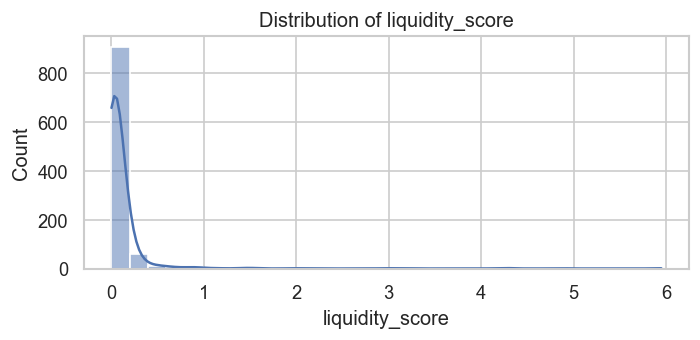

In [7]:
# Target distribution quick plot and save
plt.figure(figsize=(6,3))
sns.histplot(df['liquidity_score'].dropna(), kde=True, bins=30)
plt.title("Distribution of liquidity_score")
plt.xlabel("liquidity_score")
plt.tight_layout()
plt.savefig("../visuals/liquidity_score_distribution.png")
plt.show()

In [8]:
target = "liquidity_score"

features = df.drop(columns=[target,'coin','symbol','date'])

X = features
y = df[target]

In [9]:
# Check for any non-numeric feature columns and convert or drop
non_numeric = [c for c in X.columns if not np.issubdtype(X[c].dtype, np.number)]
if non_numeric:
    print("Non-numeric feature columns detected:", non_numeric)
    # Try simple conversion
    for c in non_numeric:
        X[c] = pd.to_numeric(X[c], errors='coerce')
    still_non_numeric = [c for c in X.columns if not np.issubdtype(X[c].dtype, np.number)]
    if still_non_numeric:
        print("Dropping still-non-numeric columns:", still_non_numeric)
        X = X.drop(columns=still_non_numeric)
        features = [c for c in features if c not in still_non_numeric]

In [10]:
# Final feature list
print("Final features used:", features)

Final features used:             price     1h    24h     7d    24h_volume       mkt_cap  \
0    4.085946e+04  0.022  0.030  0.055  3.539076e+10  7.709915e+11   
1    1.080000e+00  0.000 -0.004  0.009  9.525810e+04  1.300442e+08   
2    7.960000e+00  0.017  0.008  0.015  1.069360e+06  1.302007e+08   
3    2.949200e-01  0.023  0.010  0.045  3.041720e+03  1.327759e+08   
4    3.051000e-09  0.012 -0.005 -0.041  1.894020e+05  1.329136e+08   
..            ...    ...    ...    ...           ...           ...   
995  5.099020e-01  0.004  0.021 -0.027  2.650433e+07  4.466601e+08   
996  8.924907e-03  0.006  0.002 -0.058  8.429351e+06  4.485693e+08   
997  2.830000e-09  0.004 -0.012 -0.071  9.830393e+06  4.499018e+08   
998  2.785000e+01  0.002 -0.005 -0.147  8.810942e+06  3.911910e+08   
999  9.993870e-01  0.053  0.061 -0.122  2.027507e+04  6.731896e+07   

     liquidity_ratio  price_change_24h  
0           0.045903      1.225784e+01  
1           0.000733     -4.320000e-05  
2           0.0

In [11]:
# Display number of features
print("Number of features:", len(features))

Number of features: 1000


In [12]:
train_size = int(len(df)*0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 800
Test size: 200


In [13]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.001),
    'Elastic Net': ElasticNet(alpha=0.001),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(kernel='rbf'),
    'KNN': KNeighborsRegressor(n_neighbors=5),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

In [14]:
results = []

for name, model in models.items():
    print(f"Training {name}...")

    try:
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)

        print(f"{name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")

        joblib.dump(model, f"../models/{name.replace(' ', '_')}.pkl")

        results.append([name, rmse, mae, r2])

    except Exception as e:
        print(f"Error in {name} → {e}")

Training Linear Regression...
Linear Regression: RMSE=0.0000, MAE=0.0000, R2=1.0000
Training Ridge Regression...
Ridge Regression: RMSE=0.0035, MAE=0.0010, R2=0.9999
Training Lasso Regression...
Lasso Regression: RMSE=0.0028, MAE=0.0008, R2=0.9999
Training Elastic Net...
Elastic Net: RMSE=0.0028, MAE=0.0008, R2=0.9999
Training Random Forest...
Random Forest: RMSE=0.0127, MAE=0.0021, R2=0.9988
Training Gradient Boosting...
Gradient Boosting: RMSE=0.0188, MAE=0.0032, R2=0.9974
Training SVR...
SVR: RMSE=0.3654, MAE=0.1107, R2=0.0293
Training KNN...
KNN: RMSE=0.0823, MAE=0.0278, R2=0.9508
Training XGBoost...
XGBoost: RMSE=0.0177, MAE=0.0029, R2=0.9977


In [15]:
leaderboard = pd.DataFrame(results, columns=["Model", "RMSE", "MAE", "R2"])
leaderboard = leaderboard.sort_values("RMSE")
leaderboard.to_csv("../reports/model_performance/leaderboard.csv", index=False)

leaderboard

,Model,RMSE,MAE,R2
0,Linear Regression,1.529195e-12,2.358898e-13,1.000000
3,Elastic Net,2.795598e-03,8.399938e-04,0.999943
2,Lasso Regression,2.806247e-03,8.431844e-04,0.999943
1,Ridge Regression,3.509033e-03,1.041688e-03,0.999911
4,Random Forest,1.274348e-02,2.064090e-03,0.998820
8,XGBoost,1.765049e-02,2.881987e-03,0.997736
5,Gradient Boosting,1.878904e-02,3.167220e-03,0.997434
7,KNN,8.227206e-02,2.778882e-02,0.950802
6,SVR,3.654391e-01,1.107424e-01,0.029329


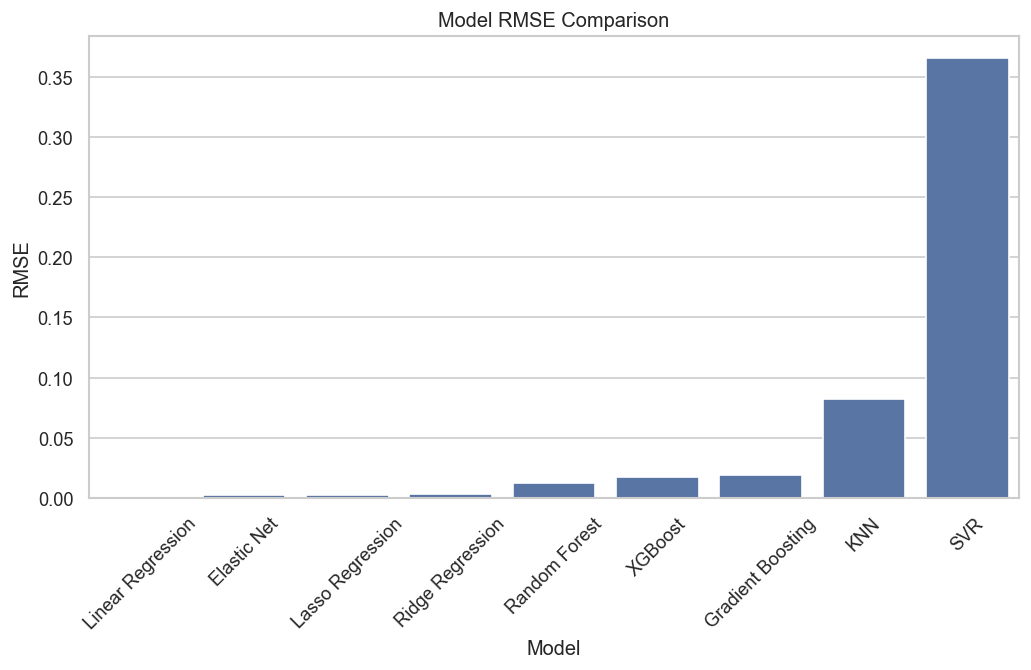

In [16]:
plt.figure(figsize=(10,5))
sns.barplot(data=leaderboard, x='Model', y='RMSE')
plt.xticks(rotation=45)
plt.title("Model RMSE Comparison")
plt.show()

In [17]:
best_model_name = leaderboard.iloc[0]["Model"]
best_model_path = f"../models/{best_model_name.replace(' ', '_')}.pkl"

best_model_name, best_model_path

('Linear Regression', '../models/Linear_Regression.pkl')

In [18]:
best_model = joblib.load(best_model_path)

# Make predictions
preds = best_model.predict(X_test)

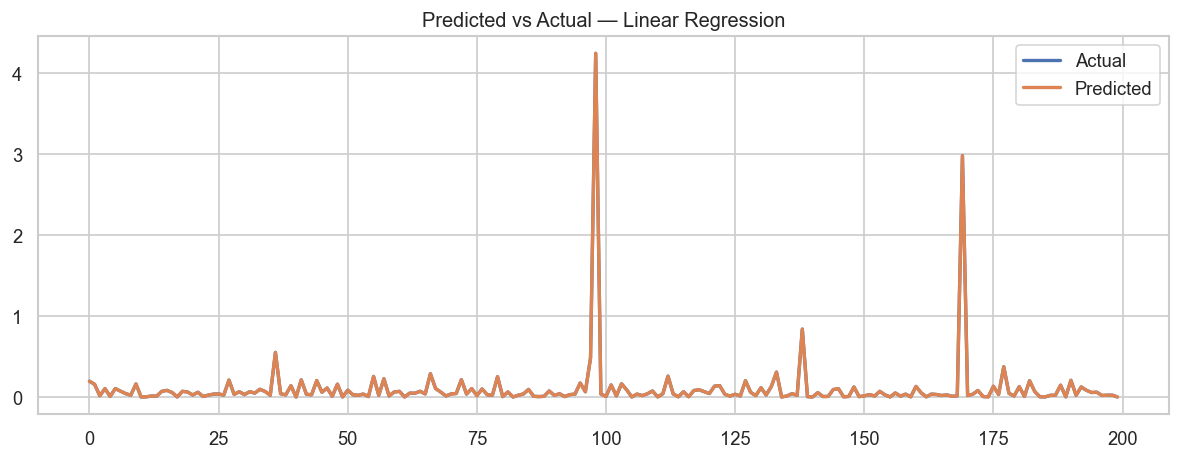

In [19]:
# Visualize Predictions vs Actual Plot
plt.figure(figsize=(10,4))
plt.plot(y_test.values, label="Actual", linewidth=2)
plt.plot(preds, label="Predicted", linewidth=2)
plt.legend()
plt.title(f"Predicted vs Actual — {best_model_name}")
plt.tight_layout()
plt.savefig("../visuals/predicted_vs_actual.png")
plt.show()

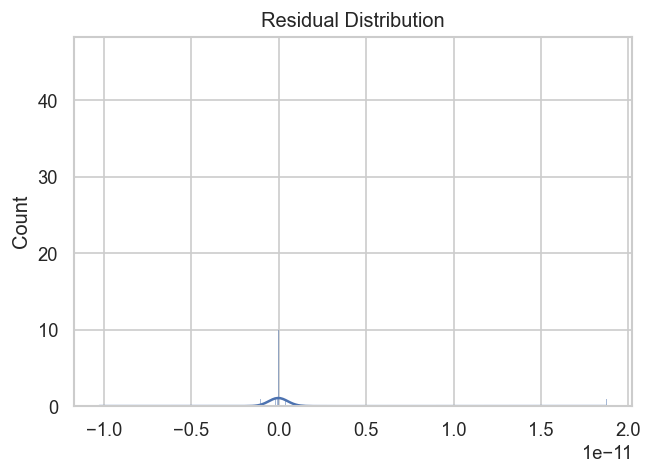

In [20]:
# Residual Plot (Distribution)
# Residuals = actual – predicted

residuals = y_test.values - preds

plt.figure(figsize=(6,4))
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.savefig("../visuals/residual_distribution.png")
plt.show()

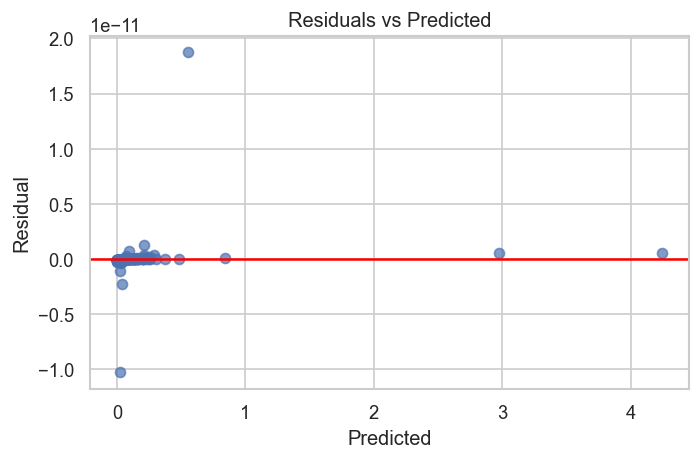

In [21]:
# Residuals vs Predicted Plot 
plt.figure(figsize=(6,4))
plt.scatter(preds, residuals, alpha=0.7)
plt.axhline(0, color='red')
plt.xlabel("Predicted")
plt.ylabel("Residual")
plt.title("Residuals vs Predicted")
plt.tight_layout()
plt.savefig("../visuals/residuals_vs_predicted.png")
plt.show()